# **Sezione riservata a Google Colab**

In [ ]:
project_folder = './drive/MyDrive/Colab_Notebooks/Progetto_Finale/'

# **Custom library**

In [ ]:
# Mia library

import sys
from math import floor

def progress_bar(executed, max = 100, pre = "", post = ""):
  sys.stdout.write('\r')
  sys.stdout.write((str(pre) + "[%-20s] %d%%" + str(post)) % ('='*floor(executed/max*20), floor(100*executed/max)))
  sys.stdout.flush()

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


class ImageDataset:

    def __init__(self, ds_name, train_test, shuffle_files=True, data_dir="./data", USPS_dir="./USPS/"):

        if ds_name == 'mnist':

            ds = tfds.load('mnist', split=train_test, shuffle_files=shuffle_files,
                                download=True, data_dir=data_dir, as_supervised=True, batch_size=-1)

        elif ds_name == 'fmnist':

            ds = tfds.load('fashion_mnist', split=train_test, shuffle_files=shuffle_files,
                                download=True, data_dir=data_dir, as_supervised=True, batch_size=-1)

        elif ds_name == 'cifar10':

            ds = tfds.load('cifar10', split=train_test, shuffle_files=shuffle_files,
                                download=True, data_dir=data_dir, as_supervised=True, batch_size=-1)

        elif ds_name == 'kmnist':

            ds = tfds.load('kmnist', split=train_test, shuffle_files=shuffle_files,
                                download=True, data_dir=data_dir, as_supervised=True, batch_size=-1)

        elif ds_name == 'emnist':

            ds = tfds.load('emnist', split=train_test, shuffle_files=shuffle_files,
                                download=True, data_dir=data_dir, as_supervised=True, batch_size=-1)

        elif ds_name == 'svhn':

            ds = tfds.load('svhn', split=train_test, shuffle_files=shuffle_files,
                                download=True, data_dir=data_dir, as_supervised=True, batch_size=-1)

        elif ds_name == 'usps':

            self.images = np.load(USPS_dir + train_test + '_x.npy')
            self.labels = np.load(USPS_dir + train_test + '_y.npy')

        else:
            raise Exception("Selected dataset is not available")

        if ds_name != 'usps':
            self.images, self.labels = tfds.as_numpy(ds)

        self.num_channels = self.images.shape[3]

    def shuffle(self):

        p = np.random.permutation(len(self.images))
        self.images = self.images[p]
        self.labels = self.labels[p]


    def normalize(self, n_bits=8):

        self.images = self.images / (2**n_bits - 1)

    def filter(self, t1, t2=None, binary=True, overwrite=False):

        images = self.images
        labels = self.labels
        target_1 = np.where(labels == t1)
        target_2 = np.where(labels == t2)

        if t2 is not None:
            images = images[np.where((labels == t1) | (labels == t2))]
            labels = labels[np.where((labels == t1) | (labels == t2))]

        target_1 = np.where(labels == t1)
        target_2 = np.where(labels == t2)

        if binary:
            labels[target_1] = 1
            labels[target_2] = 0

        if not overwrite:
          return images, labels
          
        else:
          self.images = images
          self.labels = labels

    def pad(self, target_shape=(32, 32)):
        """
        Adds symmetric zero padding to image with shape HxWxC
        :param target_shape: tuple with target shape (H,W)
        """

        self.images = np.pad(self.images, ((0,0),(2,2),(2,2),(0,0)))

    def vectorize(self, merge_channels=False):
        """
        Transforms image from pixel matrix with shape (H,W,C) to linear vector
        :param merge_channels: if True, the pixel vectors from each channel will be concatenated
        """

        self.images = np.transpose(self.images, (0, 3, 1, 2))

        if merge_channels:
            self.images = np.reshape(self.images, [len(self.images), -1])

        else:
            self.images = np.reshape(self.images, [len(self.images), self.images.shape[1], -1])

    def permute(self, n):

        perm_idx = get_permutation(n)
        if self.num_channels == 3:
            perm_idx = np.concatenate((perm_idx,perm_idx,perm_idx),0)
        self.images = self.images[:, perm_idx]

    def subset(self, shard=False, shard_number=None, validation=True, validation_size=None):

        if validation and validation_size is None:
            raise Exception("Requested training/validation split but no validation split size given.")
        if shard and shard_number is None:
            raise Exception("Requested sharding but no shard size given.")

        if validation:
            valid_images, valid_labels = self.images[0:validation_size], self.labels[0:validation_size]
            train_images, train_labels = self.images[validation_size:], self.labels[validation_size:]
            if shard:
                valid_images, valid_labels = np.array_split(valid_images, shard_number), np.array_split(valid_labels, shard_number)
                train_images, train_labels = np.array_split(train_images, shard_number), np.array_split(train_labels, shard_number)
            return train_images, train_labels, valid_images, valid_labels
        else:
            train_images, train_labels = self.images, self.labels
            if shard:
                train_images, train_labels = np.array_split(train_images, shard_number), np.array_split(train_labels, shard_number)
            return train_images, train_labels


def get_matrix(n):
    '''
     Assumes that the matrix is of size 2^n x 2^n for some n

     EXAMPLE for n=4

     Old order:

      1  2  3  4
      5  6  7  8
      9 10 11 12
     13 14 15 16

     New order:

      1  2  5  6
      3  4  7  8
      9 10 13 14
     11 12 15 16

     Function returns numbers from old order, read in the order of the new numbers:

     [1, 2, 5, 6, 3, 4, 7, 8, 9, 10, 13, 14, 11, 12, 15, 16]

     So if you previously had a data vector v from a matrix size 32 x 32,
     you can now use v[get_permutation(5)] to reorder the elements.
    '''
    if n == 0:
        return np.array([[1]])
    else:
        smaller = get_matrix(n - 1)
        num_in_smaller = 2 ** (2 * n - 2)
        first_stack = np.hstack((smaller, smaller + num_in_smaller))
        return np.vstack((first_stack, first_stack + 2 * num_in_smaller))


def get_permutation(n):
    return get_matrix(n).ravel() - 1


# **Body**

In [ ]:
import numpy as np
import gc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Inizializzazione
bs = 256
weighting = 'paired'
trials = 10
classes = 26

# USPS non disponibile per tensorflow
# ds_set = ['fmnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

ds_set = ['emnist']

# Registro l'accuratezza per ogni tupla [dataset, trial, alternativa1, alternativa2]

paired_test = np.zeros((len(ds_set), trials, classes, classes))
heatmap_matrix = np.zeros((len(ds_set), classes, classes))

# Ciclo su ogni dataset disponibile (tutti hanno 10 classi distinte)
for k, ds in enumerate(ds_set):

    print(f"- Dataset: {ds}")

    # Ciclo ogni possibile coppia di classi alternative
    for t1 in range(10, classes+10):
        for t2 in range(t1 + 1, classes+10):

            test_ds = ImageDataset(ds, 'test')
            train_ds = ImageDataset(ds, 'train')

            for x in [train_ds, test_ds]:
                x.filter(t1, t2, overwrite=True)
                x.shuffle()
                x.normalize()
                if x.images.shape[1:3] == (28, 28):
                    x.pad()
                x.vectorize(True)

            finished = False

            while not finished:

              try:

                # Carico i dati per allenare e testare l'algoritmo
                progress_bar(0, max = 10, pre = f"-- Pair {t1} - {t2}:\t")
                test_ds.shuffle()
                train_ds.shuffle()
                X_test, y_test = test_ds.subset(validation=False)
                # Per coerenza con Jones&Kording, che separano comunque in train e validation
                X_train, y_train, _, _ = train_ds.subset(shard=True, shard_number=trials, validation_size=len(X_test))

                average_acc = 0

                for m in range(trials):
   
                    # inizializzo il classificatore
                    lda = LinearDiscriminantAnalysis()

                    # addestro il classificatore
                    lda.fit(X_train[m], y_train[m])

                    # calcolo l'accuratezza del classificatore
                    score_test = lda.score(X_test, y_test)

                    # print(ds, m, i, j, score_test)

                    # Registro l'accuratezza
                    paired_test[k, m, t1-10, t2-10] = score_test

                    average_acc = average_acc + score_test

                    progress_bar(m+1, max = 10, pre = f"-- Pair {t1} - {t2}:\t")

                # Registro l'accuratezza media per trial
                heatmap_matrix[k][t1-10][t2-10], heatmap_matrix[k][t2-10][t1-10] = average_acc / trials, average_acc / trials

                progress_bar(10, max = 10, pre = f"-- Pair {t1} - {t2}:\t", post = f"\tAccuracy = {heatmap_matrix[k][t1-10][t2-10]}")
                print()

                finished = True

                del X_train, y_train, X_test, y_test, train_ds, test_ds
                gc.collect()

              except:

                print("\nAn error occurred. Repeating the pair.")

# Salvo il risultato in un binario numpy
np.save(project_folder + 'results/confused_pairs_emnist.npy', paired_test)
np.save(project_folder + 'results/confused_pairs_emnist_matrix.npy', heatmap_matrix)


# **Analisi risultati**

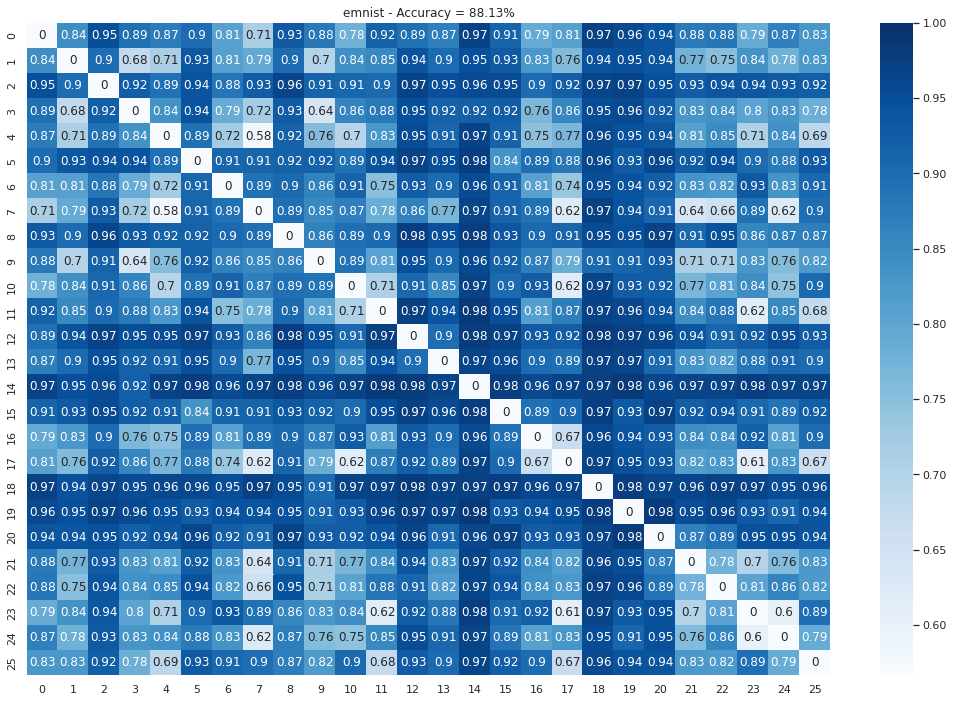

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plotto heatmap matrix

heatmap_matrix = np.load(project_folder + 'results/confused_pairs_emnist_matrix.npy')
ds_set = ['emnist']

for k in range(len(ds_set)):
    sns.set(rc= {"figure.figsize": (18, 12)})
    heat = heatmap_matrix[k]
    min_acc = .975 * min(heat[np.nonzero(heat)])
    plt.figure()
    ax = sns.heatmap(heat, annot=True, cmap='Blues', vmin = min_acc, vmax = 1)
    ax.set_title(ds_set[k] + f" - Accuracy = {round(np.mean(heat[np.nonzero(heat)])*100, 2)}%")